In [4]:
from pycromanager import Core
import ipywidgets as widgets
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pycromanager import Acquisition, multi_d_acquisition_events

import json
from pathlib import Path  
import math
import os
import shutil
from PIL import Image
import copy
import seaborn as sns
import cv2
import subprocess
import statistics
import multiprocessing 
from IPython.display import display
import matplotlib.transforms as mtransforms
from joblib import Parallel, delayed
import time
import tifffile
from tifffile import imwrite

import skimage
import warnings
warnings.filterwarnings("ignore")

def get_image_fname_based_on_channel(folder,channel):
    os.chdir(folder)
    files=[]
    taret_string='channel_'+channel
    for file in os.listdir():
        if taret_string in file:
            files.append(file)
    return files

def get_file_name(path,kind):  
    os.chdir(path)
    files=[]
    for file in os.listdir():
        if file.endswith(kind):
            files.append(file)
    return files

def medianFilter(img):
    width, height= img.size
    #create an array for resultant image
    result = np.zeros((height, width))
    #traverse through the pixels of the image
    for i in range(width):
        for j in range(height):
            #initialize variables
            currentElement=0; 
            left=0; 
            right=0; 
            top=0;
            bottom=0; 
            topLeft=0; 
            topRight=0; 
            bottomLeft=0; 
            bottomRight=0;    
            currentElement = img.getpixel((i,j))
            #offset is equal to 1 in a 3x3 filter
            offset=1
            #get left, right, bottom and top pixels
            #with respect to current pixel
            if not i-offset < 0:
                left = img.getpixel((i-offset,j))                        
            if not i+offset > width-offset:
                right = img.getpixel((i+offset,j))
            if not j-offset < 0:
                top = img.getpixel((i,j-offset))
            if not j+offset > height-1:
                bottom = img.getpixel((i,j+offset))
             #get top left, top right, bottom left and bottom right pixels
             #with respect to current pixel
            if not i-offset < 0 and not j-offset < 0:
                topLeft = img.getpixel((i-offset,j-offset))
            if not j-offset < 0 and not i+offset > width-1:
                topRight = img.getpixel((i+offset,j-offset))
            if not j+offset > height-1 and not i-offset < 0:
                bottomLeft = img.getpixel((i-offset,j+offset))
            if not j+offset > height-1 and not i+offset > width-1:
                bottomRight = img.getpixel((i+offset,j+offset))
            #get median of all pixels retrieved 
            med=statistics.median([currentElement,left,right,top,bottom,topLeft,topRight,bottomLeft,bottomRight])
            #put median in the same position in resultant array
            result[j][i] = med
    return result

def show_tiff_image(img,pos_path):
#     import cv2
#     import os
#     from matplotlib import pyplot as plt
#     import numpy as np
#     from PIL import Image
    a=np.array(img*255,dtype = np.uint8)
    img1=Image.fromarray(a)
    img1.save(os.path.join(pos_path,'check.png'))
    check_img=cv2.imread(os.path.join(pos_path,'check.png'))
    plt.imshow(check_img)


def get_file_name(path,kind):
    
    os.chdir(path)
    files=[]
    for file in os.listdir():
        if file.endswith(kind):
            files.append(file)
    return files

## Initial setting functions
def get_position(pos):
    position_name = pos['Device']['scalar']
    position_value = pos['Position_um']['array']
    if position_name == 'ZDrive':
        return {'z': position_value[0]}
    elif position_name == 'XYStage':
        return {'x': position_value[0], 'y': position_value[1]}
    else:
        return None


def get_pos_data(item):
    positions = item['DevicePositions']['array']

    pos_data = {}
    for pos in positions:
        pos_data.update(get_position(pos))

    pos_data.update({'position': item['Label']['scalar']})
    return pos_data

def create_setting(folder_name,cycle_num,cycle_type):
    experiment_name=folder_name
  
    #Image setting, including microscope-specific settings
    img_root='C:\\Users\\barscope2\\Documents\\'
    image_path=os.path.join(img_root,experiment_name)
    pos_path=image_path
    if not os.path.exists(image_path):
        os.mkdir(image_path)
        with output:
            print('Folder is created!')
    else:
        with output:
            print('Folder exist, please check if you are in first cycle')

    pixelsize=0.33
    image_siez=2048
    overlap=20
    cycle_name=cycle_type+str(cycle_num).zfill(2)
    return cycle_name,pos_path

def input_setting():       
    title_textbox = widgets.Text(
    value='',
    description='Folder_name:'
    )
    cycle_num=widgets.IntSlider(
        value=0,
        base=0,
        min=0,
        max=20,
        step=1,
        description='current_cycle_num'
    )
    cycle_type=widgets.ToggleButtons(
        options=['geneseq', 'hyb', 'barseq'],
        description='current Cycle type:',
        disabled=False,
        button_style='', # 'success', 'info', 'warning', 'danger' or ''

    #     icons=['check'] * 3
    
    )
    initial_cycle=widgets.ToggleButtons(
        options=['geneseq', 'hyb', 'barseq'],
        value='geneseq',
        description='1st Cycle:',
        disabled=False,
        button_style='', # 'success', 'info', 'warning', 'danger' or ''  
    )
    Initial_num=widgets.ToggleButtons(
        options=['00', '01'],
        value='00',        
        disabled=False,
        description='1st Cycle num:',
        button_style='', # 'success', 'info', 'warning', 'danger' or ''  
    )

    text1=widgets.Text(description='slice per slide:',
    )
    label4=widgets.Label('Please write in format like: 2 or 2,2,2,2 ')
    text2=widgets.Text(description='Last cycle:',
    )
    label5=widgets.Label('Please write in format like: geneseq01, hyb01.. keep blank if you are in first cycle.')
    lb = widgets.Button(description="confirm")
    display(title_textbox)
    display(cycle_num)
    display(cycle_type)
    display(initial_cycle)
    display(Initial_num)
    display(text1)
    display(label4)
    display(text2)
    display(label5)
    #display(lb)
    
    return title_textbox,cycle_num,cycle_type,initial_cycle,Initial_num,text1,text2,lb

def create_setting(button, folder_name,cycle_num,cycle_type,output):
    image_path=os.path.join('D:\\',folder_name.value)
    if not os.path.exists(image_path):
        os.mkdir(image_path)
        with output:
            print('Folder is created!')
    else:
        with output:
            print(f'Folder {image_path} exist, please check if you are in first cycle')
    return 

def create_image_setting(cycle_name,pos_path,text2):
    posfilename=cycle_name + '.pos'
    cycle_fun='focus'
    focusfolder=cycle_fun+cycle_name
    current_cycle_path = os.path.join(pos_path,focusfolder)
    current_image_path=os.path.join(pos_path,focusfolder)
    workpath=os.getcwd()
    if not os.path.exists(current_cycle_path):
        os.makedirs(current_cycle_path)
    if text2.value!='':
        old_name='regoffset'+text2.value+'.pos'
        new_name=cycle_name+'.pos'
        shutil.copy(os.path.join(pos_path,old_name), os.path.join(pos_path,new_name))
        print( "Copied", old_name, "as", new_name,"for focusing")
    return current_cycle_path,current_image_path,focusfolder




## focuse setting
    
def get_sharpness(pic_name, sharpen1):
    img=cv2.imread(os.path.join(current_cycle_path,pic_name), cv2.IMREAD_UNCHANGED)
    scale_percent = 50 # percent of original size
    crop_img = img[int(2048*0.4):int(2048*0.4+800), int(2048*0.4):int(2048*0.4+800)]
    width = int(crop_img.shape[1] * scale_percent / 100)
    height = int(crop_img.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized_crop_img = cv2.resize(crop_img, dim, interpolation = cv2.INTER_AREA)
    im = Image.fromarray(resized_crop_img)
    img_filter=medianFilter(im)
    sharpen_img = cv2.filter2D(img_filter, -1, sharpen1)
    gy, gx = np.gradient(sharpen_img)
    gnorm = np.sqrt(gx**2 + gy**2)
    return np.average(gnorm)
    
def get_most_focused_img(i,c_file,pos_index,sharpen1,current_image_path,focusfolder):
    target_string='position_'+str(i)
    z_stack=[f for f in c_file if target_string in f]
    sharpness = [get_sharpness(f, sharpen1) for f in z_stack]

    c_name=z_stack[np.argmax(sharpness)]
    dic_filename=c_name.replace('_C','_DIC')
    ori=os.path.join(current_image_path,dic_filename)
    new=os.path.join(pos_path,'dic'+focusfolder,dic_filename)
    shutil.copyfile(ori,new)
    focus_index=int(c_name[c_name.find('z_')+2:c_name.find('-position')])
    if z_end>=z_init:
        offset=z_init+focus_index*z_step;
    else:
        offset=z_init-focus_index*z_step;
    pos='Pos'+str(i)
    print(target_string+'is_finished')
    return pos, offset

def niefindfluorfocusfast(current_image_path,pos_path,focusfolder,cycle_name,z_init,z_end,z_step):
    if not os.path.exists(os.path.join(pos_path,'dicfocus'+cycle_name)):
        os.mkdir(os.path.join(pos_path,'dicfocus'+cycle_name))
    c_file=get_image_fname_based_on_channel(current_cycle_path,'C')
    all_file=get_file_name(current_image_path,".tif")
    pos=np.array([int(s[s.find('position_')+9:s.find('.tif')]) for s in all_file])
    pos_index=np.unique(pos)
    sharpen1 = np.array(([0, 1, 0], 
                    [-1, 5, -1], 
                    [0, -1, 0]), dtype="int")
    sharpen2 = np.array(([-2, -1, 0], 
                    [-1, 0, -1], 
                    [0, 1, 2]), dtype="int") 


    from joblib import Parallel, delayed
    results = Parallel(n_jobs=4)(delayed(get_most_focused_img)(i,c_file,pos_index,sharpen1,current_image_path,focusfolder) for i in pos_index)

    my_dict=dict(results)

    return my_dict


def load_achor_pos(pos_path,cycle_name):
    import json
    import os
    from pathlib import Path 
    import pandas as pd
    filename=cycle_name + '.pos'
    if os.path.isfile(os.path.join(pos_path,filename)):
        with open(os.path.join(pos_path,filename)) as f:
             d = json.load(f)
        result = pd.DataFrame([get_pos_data(item) for item in d['map']['StagePositions']['array']])[['position', 'x', 'y', 'z']]
    else:
        result=pd.DataFrame([])
    return result


def load_achor_pos_2(pos_path,cycle_name):
    import json
    import os
    from pathlib import Path 
    import pandas as pd
    filename='regoffset'+cycle_name + '.pos'
    if os.path.isfile(os.path.join(pos_path,filename)):
        with open(os.path.join(pos_path,filename)) as f:
             d = json.load(f)
        result = pd.DataFrame([get_pos_data(item) for item in d['map']['StagePositions']['array']])[['position', 'x', 'y', 'z']]
    else:
        result=pd.DataFrame([])
    return result
def shoot_image_for_focus(pos_path,cycle_name,z_init,z_end,z_step,current_cycle_path):
   
    poslist=load_achor_pos(pos_path,cycle_name)
    if len(poslist)==0:
        print('Can not find focusing position file!')
    else:
        poslist.to_csv(os.path.join(pos_path,cycle_name+'.csv'),index=False)
        pos=poslist
        focus_list= np.zeros((len(pos), 3)) 
        for i in range (0,len(pos)):
             focus_list[i,:]=np.array([pos.loc[i,'x'],pos.loc[i,'y'],pos.loc[i,'z']])
        os.chdir(current_cycle_path)
        single_geneseq_focus(cycle_name,current_cycle_path,focus_list, z_init,z_end,z_step)
    
    
    
def image_saved_fn(axes, dataset):
    pixels = dataset.read_image(**axes)
    im = Image.fromarray(pixels)
    im.save('-'.join([k+'_'+str(v) for k, v in axes.items()])+ '.tif')
    
def single_geneseq_focus(cycle_name,path,stage_xyz_pos,z_init,z_end,z_step):
    from pycromanager import Acquisition, multi_d_acquisition_events
    with Acquisition(directory=path,name='focus'+cycle_name, saving_queue_size=7, image_saved_fn=image_saved_fn,show_display=False) as acq:
   # with Acquisition(directory=path,name='focus'+cycle_name, saving_queue_size=7, image_saved_fn=image_saved_fn) as acq:   
            geneseq = multi_d_acquisition_events(xyz_positions=stage_xyz_pos,
                                        channels=["C","DIC"],
                                        channel_group='Channels',
                                        channel_exposures_ms =[50,10],
                                        z_start=z_init,
                                        z_end=z_end,
                                        z_step=z_step,
                                        keep_shutter_open_between_z_steps=False)
            acq.acquire(geneseq)         

def organize_focus_offset(pos_path,cycle_name,data):
    dataname='offset'+cycle_name+'.csv'
    data.to_csv(os.path.join(pos_path,dataname),index=False)
    filename=cycle_name+'.pos'
    new_filename='offset'+cycle_name+'.pos'
    with open(os.path.join(pos_path,filename)) as f:
         d = json.load(f)
    d2 = copy.deepcopy(d)
    for i in data.index:
        d2['map']['StagePositions']['array'][i]['DevicePositions']['array'][0]['Position_um']['array'][0] = data.loc[i, 'z_offset']
    json_object = json.dumps(d2, indent=2)
    with open(os.path.join(pos_path,new_filename), "w") as outfile:
        outfile.write(json_object)   
    diff=data['z_offset'].values-data['z'].values
    return diff

## alignment function


def calculate_shift(imref,imcurr,fname2):
    start_time = time.time()
    x_offset=np.zeros(4)
    y_offset=np.zeros(4)
    for i in range(4):
        ref=imref[i] # reference
        img=imcurr[i]
        start = fname2[i].find('position_') + 9
        end = fname2[i].find('.tif')
        xoffset,yoffset=imregcorr(img,ref)
        x_offset[i]=xoffset
        y_offset[i]=yoffset
        print(f"finished {i}th Element")   
    print("--- %s seconds ---" % (time.time() - start_time))
    return x_offset,y_offset
def get_file_name(path,kind):
    
    os.chdir(path)
    files=[]
    for file in os.listdir():
        if file.endswith(kind):
            files.append(file)
    return files

def sort_by(string,index):  
    ch=np.array([s[s.find('channel_')+8:s.find('-z')] for s in string])
    z=np.array([int(s[s.find('z_')+2:s.find('-position')]) for s in string])
    pos=np.array([int(s[s.find('position_')+9:s.find('.tif')]) for s in string])
    if index=='ch':
        rearrange=np.argsort(ch)
        string = [string[i] for i in rearrange]
    if index=='z':
        rearrange=np.argsort(z)
        string = [string[i] for i in rearrange]
    if index=='pos':
        rearrange=np.argsort(pos)
        string = [string[i] for i in rearrange]
    return string

def createBlackmanWindow(windowSize):
        M = windowSize[0]
        N = windowSize[1]
        a0 = 7938/18608;
        a1 = 9240/18608;
        a2 = 1430/18608;
        n=np.arange(1,N+1,1)
        m=np.arange(1,M+1,1)
        h1 = 1;
        h2 = 1;
        h1_part1=a1*np.cos(2*math.pi*m/(M-1))
        h1_part2=a2*np.cos(4*math.pi*m / (M-1))
        h2_part1=a1*np.cos(2*math.pi*n / (N-1))
        h2_part2=a2*np.cos(4*math.pi*n / (N-1))
        if M > 1:
            h1 = a0 - h1_part1 + h1_part2;
        if N > 1:
            h2 = a0 - h2_part1 + h2_part2;
        h1=h1.reshape(len(h1),1)
        h=np.multiply(h1, h2)
        return h

def machineEpsilon(func=float):
    machine_epsilon = func(1)
    while func(1)+func(machine_epsilon) != func(1):
        machine_epsilon_last = machine_epsilon
        machine_epsilon = func(machine_epsilon) / func(2)
    return machine_epsilon_last

def imregcorr(moving,fixed):
    moving=moving.astype('single');
    fixed=fixed.astype('single')
    windowSize=moving.shape
    h= createBlackmanWindow(windowSize)
    moving_1=moving*h
    fixed_1=fixed*h
    A=fixed_1
    A_l=A.tolist()
    A=np.array([round(a,3) for row in A_l for a in row]).reshape((2048, 2048))
    B=moving_1;
    B_l=B.tolist()
    B=np.array([round(b,3) for row in B_l for b in row]).reshape((2048, 2048))
    size_A  = np.array(A.shape)
    size_B  = np.array(B.shape)
    outSize = size_A + size_B - 1;
    A_trans=np.fft.fft2(A,outSize)
    B_trans=np.fft.fft2(B,outSize)
    ABConj = A_trans * np.conj(B_trans);

    eps=machineEpsilon(float)

    denominator=abs(eps+ABConj)
    d=np.fft.ifft2(ABConj / denominator)
    d_shift=np.fft.fftshift(d)
    d_shift_flatten=d_shift.flatten()
    result = np.where(d_shift_flatten == np.amax(d_shift_flatten))
    peak=np.unravel_index(result, d_shift.shape)
    ypeak=peak[0][0][0]
    xpeak=peak[1][0][0]
    u = np.real(d_shift[ypeak-1:ypeak+2, xpeak-1:xpeak+2])
    u=u.T.flatten()
    x=np.array([-1,-1,-1,0,0,0,1,1,1])
    y=np.array([-1,0,1,-1,0,1,-1,0,1])
    X=np.empty((6,9))
    X[0]=np.ones(9)
    X[1]=x
    X[2]=y
    X[3]=x*y
    X[4]=x**2
    X[5]=y**2
    A1=np.real(np.linalg.lstsq(X.T,u.T,rcond=None)[0])
    x_offset = (-A1[2]*A1[3]+2*A1[5]*A1[1]) / (A1[3]**2-4*A1[4]*A1[5])
    y_offset = -1 /(A1[3]**2-4*A1[4]*A1[5])*(A1[3]*A1[1]-2*A1[4]*A1[2])
    if not (abs(x_offset)>1 or abs(y_offset)>1):      
        x_offset = round(10*x_offset)/10;
        y_offset = round(10*y_offset)/10;    
        xpeak = xpeak+1 + x_offset;
        ypeak = ypeak+1 + y_offset;
        peakVal = np.dot(np.array([1, x_offset, y_offset, x_offset*y_offset, x_offset**2,y_offset**2]) ,A1.T);
        peakVal = float(abs(peakVal))
        gridYCenter = round(1 + (d.shape[0]-1)/2)
        gridXCenter = round(1 + (d.shape[1]-1)/2)
        xpeak_1 = xpeak-gridXCenter;
        ypeak_1 = ypeak-gridYCenter;
        if all((d == peakVal).flatten()):
            xpeak_1=0
            ypeak_1=0
        return xpeak_1,ypeak_1
                                                         
def check_image_number_compare_with_first_folder(initial_cycle,Initial_num,cycle_name,pos_path):
    firstdicfolder='dicfocus'+initial_cycle+Initial_num
    dicfolder='dicfocus'+cycle_name
    fname1=get_file_name(os.path.join(pos_path,firstdicfolder),".tif")#reference image
    fname1=sort_by(fname1,'pos')
    fname2=get_file_name(os.path.join(pos_path,dicfolder),".tif")
    fname2=sort_by(fname2,'pos')
    try:
        if len(fname2) != len(fname1):
            raise Invalidpicturenum    
    except Invalidpicturenum:
        print("The number of images is different from the first cycle. Abort.")
    return fname1,fname2

def check_image_number_in_current_folder(fname1,fname2,initial_cycle,Initial_num,cycle_name):
    init_cycle=initial_cycle+Initial_num
    stage_x_dir=-1; #-1: left is larger
    stage_y_dir=1; #1: bottom is larger
    pos_per_slice=4;  #don't change this
    slice_per_slide=text1.value
    listOfChars = list()
    listOfChars.extend(slice_per_slide)
    num = [int(x) for x in listOfChars if x.isdigit()]
    slice_per_slide=num
    pos_batch_size=[i*pos_per_slice for i in slice_per_slide]
    firstdicfolder='dicfocus'+init_cycle
    dicfolder='dicfocus'+cycle_name
    imref=[]
    imcurr=[]
    for i in fname1:
        im=cv2.imread(os.path.join(pos_path,firstdicfolder,i),cv2.IMREAD_UNCHANGED)
        imref.append(im)
    for j in fname2:
        im=cv2.imread(os.path.join(pos_path,dicfolder,j),cv2.IMREAD_UNCHANGED)
        imcurr.append(im)
    imref=np.array(imref)
    imcurr=np.array(imcurr)
    slidenum=np.zeros(sum(pos_batch_size))
    slidenum[0:pos_batch_size[0]]=1
    for i in range(1,len(pos_batch_size)):
        slidenum[sum(pos_batch_size[0:i]):sum(pos_batch_size[0:i+1])]=i+1
    try:
        if len(slidenum)!=len(imcurr):
            raise Invalidslidenum
    except Invalidslidenum:
        print("The number of images is different from slice numbers. Abort.")
    return imref,imcurr,slidenum

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    
def sanity_check_alignment(slidenum,x_offset,y_offset):
    pos_per_slice=4
    x_translation_pooled=np.zeros(len(slidenum))
    y_translation_pooled=np.zeros(len(slidenum))
    uniqslidenum=np.unique(slidenum);
    for i in uniqslidenum:
        x_median=np.median(x_offset[np.where(slidenum == i)])
        y_median=np.median(y_offset[np.where(slidenum == i)])
        x_translation_pooled[np.where(slidenum == i)]=x_median
        y_translation_pooled[np.where(slidenum == i)]=y_median
    for i in uniqslidenum:
        x_sub=x_offset[np.where(slidenum == i)]
        y_sub=y_offset[np.where(slidenum == i)]
        max_range_xy=max(np.ptp(x_sub,axis=0),np.ptp(y_sub,axis=0))
        x_extreme_diff=np.median(x_sub[0:pos_per_slice])-np.median(x_sub[-pos_per_slice:])
        y_extreme_diff=np.median(y_sub[0:pos_per_slice])-np.median(y_sub[-pos_per_slice:])
        if x_extreme_diff>50:
            print(bcolors.WARNING +'Slide '+str(i)+' is tilted COUNTER CLOCKWISE.')
        if x_extreme_diff<-50:
            print(bcolors.WARNING +'Slide '+str(i)+' is tilted CLOCKWISE')
        if max_range_xy>50:
            print(bcolors.WARNING +'Slide '+str(i)+' is tilted CLOCKWISEgrossly tilted and/or some registrations have failed. Double-check fixed positions.')
    return x_translation_pooled,y_translation_pooled
def save_regoffset_pos(cycle_name,pos_path,data):
    filename='offset'+cycle_name+'.pos'
    new_filename='regoffset'+cycle_name+'.pos'
    with open(os.path.join(pos_path,filename)) as f:
         d = json.load(f)
    d2 = copy.deepcopy(d)
    for i in data.index:
        d2['map']['StagePositions']['array'][i]['DevicePositions']['array'][1]['Position_um']['array'][0]=df.loc[i, 'x_offset']
        d2['map']['StagePositions']['array'][i]['DevicePositions']['array'][1]['Position_um']['array'][1]=df.loc[i, 'y_offset']
    json_object = json.dumps(d2, indent=2)
    with open(os.path.join(pos_path,new_filename), "w") as outfile:
        outfile.write(json_object)   
###Redo focus and alignment
def check_redo(pos_path,cycle_name):
    import ipywidgets as widgets
    import os
    import shutil
    import subprocess
    button = widgets.Button(description="Delete all current folders")
    output = widgets.Output()
    display(button, output)
    def on_button_clicked(b):
        with output:
            shutil.rmtree(os.path.join(pos_path,'focus'+cycle_name), ignore_errors=True)
            shutil.rmtree(os.path.join(pos_path,'dicfocus'+cycle_name), ignore_errors=True)
    button.on_click(on_button_clicked)  

### Make tiles
def multiple(num):
    return num*1000

def ind2sub(array_shape, ind):
    # Gives repeated indices, replicates matlabs ind2sub
    cols = (ind.astype("int32") // array_shape[0])
    rows = (ind.astype("int32") % array_shape[0])
    return (rows, cols)

def createtiles(data3,pixelsize,imwidth,overlap):
    tileconfig = [None] * (math.floor(len(data3)/4))
    lablelist=[]
    poslist=[]
    Slide=[]
    number=[]
    pos=[]
    for i in range(0,math.floor(len(data3)/4)): 
        y=data3['y'][i*4:(i+1)*4].to_numpy(dtype=float)
        x=data3['x'][i*4:(i+1)*4].to_numpy(dtype=float)
        z=data3['z'][i*4:(i+1)*4].to_numpy(dtype=float)

        #calculate midpoint xy
        midpointx=np.ptp(x)/2+np.min(x)  
        midpointy=np.ptp(y)/2+np.min(y)
        #regress z slope and midpoint on xy
        a = np.array([x-midpointx, y-midpointy, np.ones(len(x))])
        z1=np.linalg.lstsq(a.T, np.array([z]).T,  rcond=None)[0]
        zslopex=z1[0];
        zslopey=z1[1];
        midpointz=z1[2];
        #calculate tile config
        tileconfig[i]=[math.ceil(np.ptp(x)/(imwidth*(1-overlap/100)*pixelsize))+1, math.ceil(np.ptp(y)/(imwidth*(1-overlap/100)*pixelsize))+1]
        midpoint=[tileconfig[i][0]/2-0.5,tileconfig[i][1]/2-0.5]

        for n in range(0,tileconfig[i][0]*tileconfig[i][1]):
                grid_col,grid_row=ind2sub(tileconfig[i],np.array(n))
                #change LABEL
                LABEL=['Pos'+str(i+1)+
                        '_'+str(grid_col).zfill(3)+
                        '_'+str(grid_row).zfill(3)]
                #change XY positions
                Yoffset=(grid_row-midpoint[1])*imwidth*(1-overlap/100)*pixelsize;
                Xoffset=(grid_col-midpoint[0])*imwidth*(1-overlap/100)*pixelsize;
                Y=round(midpointy+Yoffset);
                X=round(midpointx+Xoffset);
                #find the device of XYstage
                Zoffset=Yoffset*zslopey + Xoffset*zslopex;
                Z=midpointz+Zoffset;
                poslist.append([X,Y,Z[0]])
                lablelist.append(LABEL[0])
                Slide.append('slide_'+str(i+1))
                pos.append('Pos'+str(i+1))
                number.append(n)


    tilepos=pd.DataFrame(columns=['Slidenum','Posinfo', 'X', 'Y','Z'])
    tilepos['Slidenum']=Slide
    tilepos['Posinfo']=lablelist
    tilepos['Pos']=pos
    tilepos['X']=[pos[0] for pos in poslist ]
    tilepos['Y']=[pos[1] for pos in poslist ]
    tilepos['Z']=[pos[2] for pos in poslist ]
    return tilepos
## max projection
def single_geneseq_sub_cycle(cycle_name,path,stage_xyz_pos,z_init,z_end,z_step,):
    from pycromanager import Acquisition, multi_d_acquisition_events
    with Acquisition(directory=path,
                     name='focus'+cycle_name,
                     image_saved_fn=image_saved_fn_for_maxprojection
                     #show_display=False
                    ) as acq:
          
            geneseq = multi_d_acquisition_events(xyz_positions=stage_xyz_pos,
                                        channels=["G","T","A","C"],
                                        channel_group='Channels',
                                        channel_exposures_ms =[100,150,200,250,10],
                                        z_start=z_init,
                                        z_end=z_end,
                                        z_step=z_step,
                                        keep_shutter_open_between_z_steps=False)
            acq.acquire(geneseq) 
            
            
            
sharpen1 = np.array(([0, 1, 0], 
                    [-1, 5, -1], 
                    [0, -1, 0]), dtype="int")
def cal_sharpness_2(ind, dataset):
    #print(ind)
    pixels = dataset.read_image(**ind)
    width = int(pixels.shape[1] *0.1)
    height = int(pixels.shape[0] * 0.1)
    dim = (width, height)
    resized_crop_img = cv2.resize(pixels, dim, interpolation = cv2.INTER_AREA)
    im = Image.fromarray(resized_crop_img)
    img_filter=medianFilter(im)
    sharpen_img = cv2.filter2D(img_filter, -1, sharpen1)
    gy, gx = np.gradient(sharpen_img)
    gnorm = np.sqrt(gx**2 + gy**2)
    sharpness=np.average(gnorm)
    return sharpness
def get_pixel(ind, dataset):
    pixels = dataset.read_image(**ind)
    return pixels

def maxprojection(img_group):
    maxprojection_image=np.max(img_group, axis=(0))
    return maxprojection_image


        
def get_pos(image_file_name):
    start=image_file_name.find('_')+1
    end=image_file_name.find('_',4)
    return image_file_name[start:end]

def get_row(image_file_name):
    start=image_file_name.find('_')+1
    end=start+3
    return int(image_file_name[start:end])

def get_col(image_file_name):
    start=image_file_name.find('_',7)+1
    end=start+3
    return int(image_file_name[start:end])
def fix_Posinfo(tilepos):
    tilepos_new=pd.DataFrame(columns=['Slidenum','Posinfo','X','Y','Z','Pos','switched_Posinfo'])
    slice_ls=pd.unique(tilepos['Pos'])
    for s in slice_ls:
        image_name_df=tilepos[tilepos['Pos']==s]
        image_name=image_name_df['Posinfo']
        col_list=[get_col(i) for i in image_name ]
        row_list=[get_row(i) for i in image_name ]      
        row_list_new=[str(max(row_list)-i).zfill(3) for i in row_list]
        col_list_new=[str(max(col_list)-i).zfill(3) for i in col_list]
        new_name=[]
        for num in range(len(row_list_new)):
            name=s+"_"+row_list_new[num]+"_"+col_list_new[num]
            new_name.append(name)
        image_name_df['switched_Posinfo']=new_name
        frames = [tilepos_new,image_name_df]
        tilepos_new = pd.concat(frames)
    return tilepos_new
def Assign_image_channel(cycle_name,stack_num):
    if ('geneseq' in cycle_name or 'bcseq' in cycle_name) and '01' in cycle_name:
        channel_list=["G","T","A","C","DIC"]
        channel_Intensity=[100,150,200,250,10]
        channel_number=len(channel_list)
        save_fn_trigger=stack_num*channel_number
    elif ('geneseq' in cycle_name or 'bcseq' in cycle_name)and ~('01' in cycle_name):
            channel_list=["G","T","A","C"]
            channel_Intensity=[100,150,200,250]
            channel_number=len(channel_list)
            save_fn_trigger=stack_num*channel_number
    else:   
        channel_list=["hyb"]
        channel_Intensity=[100,150,200,250]
        channel_number=len(channel_list)
        save_fn_trigger=stack_num*channel_number
    return channel_list,channel_Intensity,save_fn_trigger

def save_and_maxprojection(axes, dataset):
    if len(dataset.get_index_keys())%save_fn_trigger == 0:
        dataset_indices = dataset.get_index_keys()[-save_fn_trigger:]
        start_time = time.time()
        print('Start maxprojection.....')
        dataset_indices = dataset.get_index_keys()[-save_fn_trigger:]
        pixel=[get_pixel(ind, dataset)for ind in dataset_indices]
        stack_channel_list=[ind['channel'] for ind in dataset_indices]
        maxproj_img=[]
        for channel in channel_list:
            index=[i for i, e in enumerate(stack_channel_list) if e == channel]
            img_group=np.array([pixel[i] for i in index])
            maxprojection_image= maxprojection(img_group)
            maxproj_img.append(maxprojection_image)
        pos=dataset_indices[0]['position']
        pos_name=pos_list.loc[pos,'switched_Posinfo'] 
        maxpro_img_merge=np.array(maxproj_img)
        skimage.io.imsave('Max_'+ pos_name+'.tif', maxpro_img_merge,photometric='minisblack')

def image_cycle(cycle_name,path,stage_xyz_pos,z_init,z_end,z_step,channel_list,channel_Intensity):
    from pycromanager import Acquisition, multi_d_acquisition_events
    with Acquisition(directory=path,
                     name=cycle_name,
                     saving_queue_size=12,
                     image_saved_fn=self_defined_image_save_and_maxprojection
                     #show_display=False
                     ) as acq:
          
            geneseq = multi_d_acquisition_events(xyz_positions=stage_xyz_pos,
                                        channels=channel_list,
                                        channel_group='Channels',
                                        channel_exposures_ms =channel_Intensity,
                                        z_start=z_init,
                                        z_end=z_end,
                                        z_step=z_step,
                                        keep_shutter_open_between_z_steps=False)
            acq.acquire(geneseq) 
            return 

## Set experiment name (Must run before runing any other followed functions)

In [5]:
title_textbox,cycle_num,cycle_type,initial_cycle,Initial_num,text1,text2,lb=input_setting() 
output = widgets.Output()
import functools
lb.on_click(functools.partial(create_setting,folder_name=title_textbox,
            cycle_num = cycle_num,
            cycle_type = cycle_type,
            output = output))
display(lb)
display(output)

Text(value='', description='Folder_name:')

IntSlider(value=0, description='current_cycle_num', max=20)

ToggleButtons(description='current Cycle type:', options=('geneseq', 'hyb', 'barseq'), value='geneseq')

ToggleButtons(description='1st Cycle:', options=('geneseq', 'hyb', 'barseq'), value='geneseq')

ToggleButtons(description='1st Cycle num:', options=('00', '01'), value='00')

Text(value='', description='slice per slide:')

Label(value='Please write in format like: 2 or 2,2,2,2 ')

Text(value='', description='Last cycle:')

Label(value='Please write in format like: geneseq01, hyb01.. keep blank if you are in first cycle.')

Button(description='confirm', style=ButtonStyle())

Output()

In [65]:

pos_path=os.path.join('D:\\',title_textbox.value)
cycle_name=cycle_type.value+str(cycle_num.value).zfill(2)
current_cycle_path,current_image_path,focusfolder=create_image_setting(cycle_name,pos_path,text2)
core = Core()
z_init=-15
z_end=15
z_step=1.5
os.chdir(pos_path)

Copied regoffsetgeneseq01.pos as geneseq02.pos for focusing


## Focusing

#### Initialize parameter and shoot images for focus cycle

In [66]:
if not os.path.exists(current_cycle_path):
        os.makedirs(current_cycle_path)

core = Core()
shoot_image_for_focus(pos_path,cycle_name,z_init,z_end,z_step,current_cycle_path)
os.chdir(pos_path)

#### calculate focusing

52.71132159233093

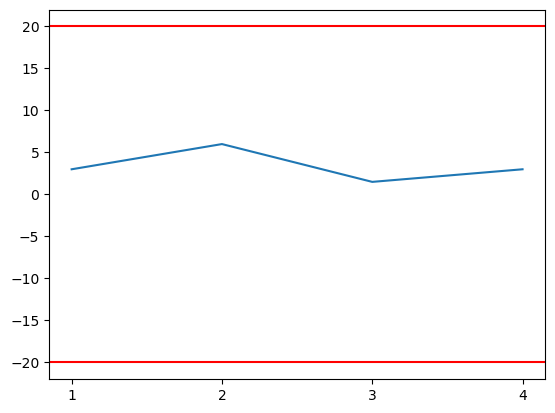

In [67]:
# check bug! directory not changes
import time
start_time = time.time()
my_dict=niefindfluorfocusfast(current_image_path,pos_path,focusfolder,cycle_name,z_init,z_end,z_step)
data=pd.read_csv(os.path.join(pos_path,cycle_name+'.csv'))
data['z_offset']=0
for i in range(len(data)):
    data.loc[i,'z_offset']=my_dict[ data.iloc[i,0]]+data.loc[i,'z']
diff=organize_focus_offset(pos_path,cycle_name,data)
x=list(range(1,len(diff)+1,1))
g = sns.lineplot(x=x, y=diff)
g.set_xticks(np.arange(1,len(diff)+1))
g.axhline(20,color='red')
g.axhline(-20,color='red')
time.time()-start_time

## Alignment

#### calculate shift

In [69]:
##check if you are in first cycle then copy offset to regoffset, skip alignment
fname1,fname2=check_image_number_compare_with_first_folder(initial_cycle.value,Initial_num.value,cycle_name,pos_path) #fname1 is first cycle dic
imref,imcurr,slidenum=check_image_number_in_current_folder(fname1,fname2,initial_cycle.value,Initial_num.value,cycle_name) ##imref imcurr follow the order of pos 0 to n
x_offset,y_offset=calculate_shift(imref,imcurr,fname2)
x_translation_pooled,y_translation_pooled=sanity_check_alignment(slidenum,x_offset,y_offset)
pixelsize=0.33
stage_x_dir=-1; #-1: left is larger
stage_y_dir=1; #1: bottom is larger
df=pd.read_csv(os.path.join(pos_path,'offset'+cycle_name+'.csv'))
df['x_offset']=df['x']-stage_x_dir*x_translation_pooled*pixelsize
df['y_offset']=df['y']-stage_y_dir*y_translation_pooled*pixelsize
df.to_csv(os.path.join(pos_path,'regoffset'+cycle_name+'.csv'),index=False)
save_regoffset_pos(cycle_name,pos_path,df)

finished 0th Element
finished 1th Element
finished 2th Element
finished 3th Element
--- 43.804017305374146 seconds ---


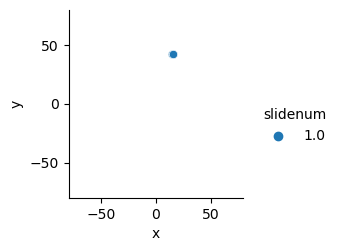

In [76]:
data=pd.DataFrame(columns=['x', 'y', 'slidenum'])
uniqslidenum=np.unique(slidenum)
for i in uniqslidenum:
    data1=pd.DataFrame(columns=['x', 'y', 'slidenum'])
    data1['x']=np.round((x_offset[np.where(slidenum == i)]))
    data1['y']=np.round((y_offset[np.where(slidenum == i)]))
    data1['slidenum']=str(i)
    data=pd.concat([data,data1],ignore_index=True)
g=sns.pairplot(x_vars=['x'], y_vars=['y'], data=data, hue="slidenum")
g.set(ylim=(-80,80))
g.set(xlim=(-80,80))

### Need redo focusing and alignment?

In [78]:
utils.check_redo(pos_path,cycle_name)

Button(description='Delete all current folders', style=ButtonStyle())

Output()

## Make tiles

In [92]:
#data3=pd.read_csv(os.path.join(pos_path,'regoffset'+cycle_name+'.csv'),header=0)
data3=load_achor_pos_2(pos_path,cycle_name)
pixelsize=0.33
imwidth=2048
overlap=10
tilepos=createtiles(data3,pixelsize,imwidth,overlap)
tilepos_new=fix_Posinfo(tilepos)
tilepos_new.to_csv(os.path.join(pos_path,'tiledregoffset'+cycle_name+'.csv'),index=False)
tilepos_new

,Slidenum,Posinfo,X,Y,Z,Pos,switched_Posinfo
0,slide_1,Pos1_000_000,1768,-245,2342.270355,Pos1,Pos1_002_002
1,slide_1,Pos1_001_000,2377,-245,2339.541013,Pos1,Pos1_001_002
2,slide_1,Pos1_002_000,2985,-245,2336.81167,Pos1,Pos1_000_002
3,slide_1,Pos1_000_001,1768,363,2341.199176,Pos1,Pos1_002_001
4,slide_1,Pos1_001_001,2377,363,2338.469833,Pos1,Pos1_001_001
5,slide_1,Pos1_002_001,2985,363,2335.74049,Pos1,Pos1_000_001
6,slide_1,Pos1_000_002,1768,972,2340.127996,Pos1,Pos1_002_000
7,slide_1,Pos1_001_002,2377,972,2337.398653,Pos1,Pos1_001_000
8,slide_1,Pos1_002_002,2985,972,2334.66931,Pos1,Pos1_000_000


## Shoot image and do maxprojection

In [93]:
if os.path.isfile(os.path.join(pos_path,'tiledregoffset'+cycle_name+'.csv')):
    poslist=pd.read_csv(os.path.join(pos_path,'tiledregoffset'+cycle_name+'.csv'))
    poslist
    maxproject_list= np.zeros((len(poslist), 3)) 
    for i in range (0,len(poslist)):
         maxproject_list[i,:]=np.array([poslist.loc[i,'X'],poslist.loc[i,'Y'],poslist.loc[i,'Z']])
else:
    print(colored("Can't find tiledregoff"+cycle_name+" datafile!",'red'))

if cycle_num.value !=0:
    image_path=os.path.join(pos_path,cycle_name)
    if not os.path.exists(image_path):
        os.mkdir(image_path)
        print('Maxprojection Folder is created!')
        channel_list=[]
        channel_Intensity=[]
        z_init=-15
        z_end=15
        z_step=1.5
        stack_num=round(abs(z_end-z_init)/z_step+1)
        channel_list,channel_Intensity,save_fn_trigger=Assign_image_channel(cycle_name,stack_num)
        if channel_list!=['']:
            start_time=time.time()
            os.chdir(image_path)
            #image_cycle(cycle_name,path,stage_xyz_pos,z_init,z_end,z_step,channel_list,channel_Intensity)
            os.chdir(pos_path)
            print("--- %s seconds ---" % (time.time() - start_time))
        else:
            print("Can not load image channel!")
    else:
        print('Maxprojection Folder is already created! Please double check!')
if cycle_num.value ==0:
    print('Cycle 00 does not need to do whole image and maxprojection!')

Maxprojection Folder is created!
